In [1]:
import warnings
warnings.filterwarnings('ignore')

### 패션 MNIST 데이터 불러오기

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1,28,28,1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state = 42
)

- keras에서 입력데이터가 3차원으로 구성되어 있을 것이라고 가정하고 있으므로 차원을 추가해서 channel차원으로 1을 추가하였음
- train set을 train과 valid로 구분

# 합성곱 신경망 만들기

In [3]:
model = keras.Sequential()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-21 12:42:06.433664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 12:42:06.433971: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.add(
    keras.layers.Conv2D(
        32, 
        kernel_size = 3, # 3x3x1
        activation = 'relu',
        padding = 'same',
        input_shape = (28,28,1)
    )
)


In [5]:
model.add(keras.layers.MaxPool2D(2)) 

In [6]:
model.add(
    keras.layers.Conv2D(
        64,
        kernel_size = 3, # 얘는 3x3x32
        activation = 'relu',
        padding = 'same'
    )
)

In [7]:
model.add(keras.layers.MaxPooling2D(2))

In [8]:
model.add(keras.layers.Flatten()) # 3차원데이터도 1차원으로 펴줌 무조건
model.add(keras.layers.Dense(100, activation= 'relu'))
model.add(keras.layers.Dropout(0.4)) # 40프로 정도 
model.add(keras.layers.Dense(10,activation = 'softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

### Model Compile과 훈련

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics= 'accuracy'
)

checkpoint_cb = keras.callbacks.ModelCheckpoint('../Data/best_cnn_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2 , restore_best_weights= True)

history = model.fit(
    train_scaled,
    train_target,
    epochs=20,
    validation_data = (val_scaled,val_target),
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


2022-07-21 12:42:09.043183: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-21 12:42:09.463231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 102/1500 [=>............................] - ETA: 16s - loss: 1.1179 - accuracy: 0.6131

KeyboardInterrupt: 

In [11]:
# 시각화 해보기
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

NameError: name 'history' is not defined

In [12]:
model.evaluate(val_scaled, val_target)

 20/375 [>.............................] - ETA: 1s - loss: 0.5385 - accuracy: 0.8109

2022-07-21 12:42:15.150554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 2s 5ms/step - loss: 0.6075 - accuracy: 0.7815


[0.6075140237808228, 0.781499981880188]

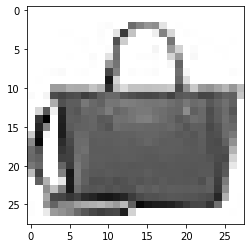

In [13]:
# 이미지로 확인해보기
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [14]:
pred = model.predict(val_scaled[0:1])
print(pred)

2022-07-21 12:42:17.351402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 667ms/step
[[3.4480136e-06 5.3144154e-06 7.2625167e-05 3.8786579e-06 1.1463797e-04
  2.4878889e-05 1.0809584e-04 1.0202256e-03 9.9863422e-01 1.2668890e-05]]


In [15]:
# 계단함수
import numpy as np
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵글부츠']

In [16]:
print(classes[np.argmax(pred)])

가방


### 시험 데이터를 확인하기

In [17]:
test_scaled = test_input.reshape(-1,28,28,1) / 255.0

In [18]:
model.evaluate(test_scaled,test_target)

 17/313 [>.............................] - ETA: 1s - loss: 0.5829 - accuracy: 0.7923

2022-07-21 12:42:19.699249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.6177 - accuracy: 0.7765


[0.6176831126213074, 0.7765000462532043]

In [19]:
import numpy as np
fruits = np.load('../Data/fruits.npy')
fruits.shape

(300, 100, 100)

In [20]:
fruits[0].shape

(100, 100)

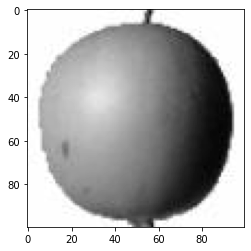

In [21]:
# image 확인하기
import matplotlib.pyplot as plt

plt.imshow(fruits[0], cmap = 'gray_r')
plt.show()

In [22]:
# Target 만들기
target = np.concatenate([np.zeros(100), np.ones(100), np.full(100,2)])
target.shape

(300,)

### train과 test로 분류하기

In [23]:
train = fruits.reshape(-1,100,100,1) / 255.0


In [36]:
from sklearn.model_selection import train_test_split

trainData, testData, trainTargetData, testTargetData = train_test_split(
    train,target,test_size=0.2 , random_state=42
)
trainData, valData, trainTargetData, valTargetData = train_test_split(
    trainData,trainTargetData,test_size=0.2 , random_state=42
)

In [37]:
print(trainData.shape)
print(valData.shape)
print(trainData.shape)
print(valTargetData.shape)

(192, 100, 100, 1)
(48, 100, 100, 1)
(192, 100, 100, 1)
(48,)


---
## CNN 만들기

In [38]:
from tensorflow import keras

In [39]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(
    32,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same',
    input_shape = (100,100,1)
    ))

model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Conv2D(
    64,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same'
    ))
model.add(keras.layers.MaxPool2D(2))




In [40]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation= 'relu'))
model.add(keras.layers.Dense(3, activation= 'softmax'))

In [41]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [42]:
model.add(keras.layers.Dropout(0.4)) # 40프로 정도 

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [44]:
checkpoint_cb2 = keras.callbacks.ModelCheckpoint('../Data/fruits_best_cnnmodel.f5')
early_stopping_cb2= keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True )

model.fit(
    trainData,
    trainTargetData,
    epochs = 20,
    validation_data = (valData,valTargetData),
    callbacks = [checkpoint_cb2,early_stopping_cb2]
)

Epoch 1/20
1/6 [====>.........................] - ETA: 2s - loss: 6.5358 - accuracy: 0.2188

2022-07-21 12:50:15.258713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/6 [========================>.....] - ETA: 0s - loss: 5.6083 - accuracy: 0.3812

2022-07-21 12:50:15.720883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 2s 250ms/step - loss: 5.1809 - accuracy: 0.3802 - val_loss: 1.3119 - val_accuracy: 0.5417
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 2.3498 - accuracy: 0.5063

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 219ms/step - loss: 2.2541 - accuracy: 0.5208 - val_loss: 0.0456 - val_accuracy: 0.9792
Epoch 3/20
5/6 [========================>.....] - ETA: 0s - loss: 0.6511 - accuracy: 0.6687

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 219ms/step - loss: 0.5941 - accuracy: 0.6771 - val_loss: 0.1295 - val_accuracy: 0.9792
Epoch 4/20
5/6 [========================>.....] - ETA: 0s - loss: 0.4976 - accuracy: 0.6375

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 217ms/step - loss: 0.5497 - accuracy: 0.6510 - val_loss: 0.0284 - val_accuracy: 0.9792
Epoch 5/20
5/6 [========================>.....] - ETA: 0s - loss: 0.5631 - accuracy: 0.6375

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 195ms/step - loss: 0.5379 - accuracy: 0.6406 - val_loss: 6.8412e-05 - val_accuracy: 1.0000
Epoch 6/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3433 - accuracy: 0.7375

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 214ms/step - loss: 0.3662 - accuracy: 0.7240 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 7/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3857 - accuracy: 0.7875

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 237ms/step - loss: 0.4072 - accuracy: 0.7552 - val_loss: 3.4257e-07 - val_accuracy: 1.0000
Epoch 8/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3672 - accuracy: 0.7500

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 224ms/step - loss: 0.3861 - accuracy: 0.7292 - val_loss: 3.5462e-07 - val_accuracy: 1.0000
Epoch 9/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3776 - accuracy: 0.7125

INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


INFO:tensorflow:Assets written to: ../Data/fruits_best_cnnmodel.f5/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.3948 - accuracy: 0.6979 - val_loss: 4.3036e-07 - val_accuracy: 1.0000


In [46]:
model.evaluate(testData,testTargetData)

2/2 [==============================] - 0s 62ms/step - loss: 0.0014 - accuracy: 1.0000


[0.0014412789605557919, 1.0]